# 4A. Population-level model with PopNet

The interface for using DiPDE/PopNet is similar to BioNet and PointNet and will hopefully look familiar by now, but there are some differences.

As before we have two options for building our GLIF Model:
1. Build from scratch using BMTK's NetworkBuilder
2. Copy an existing biophysical/point model and modify the node_types and edge_types params.

### Building PopNet version of the L4 Model
Some things to take note of:
* Populations don't have individual cells so essentially we need **N**=1, which is the same as using the default option.
* For **model_type** we want to use option 'population'.
* Unlike with the Biophysical and GLIF model, there are no optimized DiPDE/PopNet models in the Allen-Cell Types database. Instead we need to build the **dynamics_params** parameter files from scratch (we'll briefly explain the options available).
* There are only two types of **model_templates** for DiPDE/PopNet - "Internal" and "External" (equivalent to virtual cells). 


In [1]:
from bmtk.builder import NetworkBuilder


# Create and Build the L4 model
l4 = NetworkBuilder('l4')
l4.add_nodes(
    model_name='Scnn1a',
    ei_type='e',
    model_type='population',
    model_template='dipde:Internal',
    dynamics_params='Scnn1a_pop_model.json'
)

l4.add_nodes(
    model_name='Rorb',
    ei_type='e',
    model_type='population',
    model_template='dipde:Internal',
    dynamics_params='Rorb_pop_model.json'
)

l4.add_nodes(
    model_name='Nr5a1',
    ei_type='e',
    model_type='population',
    model_template='dipde:Internal',
    dynamics_params='Nr5a1_pop_model.json'
)

l4.add_nodes(
    model_name='Pvalb',
    ei_type='i',
    model_type='population',
    model_template='dipde:Internal',
    dynamics_params='Pvalb_pop_model.json'
)


# Recurrently connect internal populations
def exc_exc_conns(source, target):
    if source['node_id'] == target['node_id']:
        return 0
    else:
        return 2


l4.add_edges(
    source={'ei_type': 'e'}, target={'ei_type': 'e'},
    syn_weight=0.01,
    connection_rule=exc_exc_conns,
    delay=0.002,
    dynamics_params='dipde_ExcToInh.json'

)

l4.add_edges(
    source={'ei_type': 'e'}, target={'ei_type': 'i'},
    syn_weight=0.005,
    nsyns=20,
    delay=0.002,
    dynamics_params='dipde_ExcToInh.json'
)

l4.add_edges(
    source={'ei_type': 'i'}, target={'ei_type': 'e'},
    syn_weight=-0.002,
    nsyns=10,
    delay=0.002,
    dynamics_params='dipde_InhToExc.json'
)

l4.build()
l4.save(output_dir='network_popnet')

Now for our LGN cells:

In [2]:
lgn = NetworkBuilder('lgn')
lgn.add_nodes(
    pop_name='tON',
    ei='e',
    model_type='virtual',
    model_template='dipde:External'
)

# Connect external pop to internal pops
lgn.add_edges(
    source=lgn.nodes(),
    target=l4.nodes(),
    syn_weight=0.0025,
    nsyns=10,
    delay=0.002,
    dynamics_params='dipde_ExcToExc.json'
)

lgn.build()
lgn.save(output_dir='network_popnet')

### Setting up the environment

We can again use our helper function either through the command line

```bash
  $python -m bmtk.utils.create_environment                \
              --config-file config.popnet.json            \
              --network-dir network_popnet                \
              --output-dir output_popnet                  \
              --tstop 3000.0                              \
              --dt 0.002                                  \
              --rates-inputs lgn:inputs/lgn_pop_rates.csv \
              --run-script run_popnet.py                  \
              --overwrite                                 \
              popnet .

```

or in the notebook:

In [3]:
from bmtk.utils.create_environment import create_environment

create_environment(
    'popnet',
    base_dir='.',
    config_file='config.popnet.json',
    network_dir='network_popnet',
    output_dir='output_popnet',
    tstop=3000.0, dt=0.002,
    rates_inputs=[('lgn', 'inputs/lgn_pop_rates.csv')],
    run_script='run_popnet.py',
    # overwrite=True,
)

ERROR:root:Configuration file /home/ping/bmtk_workshop/bmtk_workshop_2022/Ch4_pointnet/config.popnet.json already exists, skipping. Please delete existing file, use a different name, or use overwrite=True.


#### Inputs

Unlike BioNet and PointNet, PopNet is not a spiking simulator and instead records the changes in firing-rates. As such the inputs to the LGN External files are not expecting individual spike-train files, but rather a list of firing rates for the External populations (currently firing rates must be constant, not time varying).

<table style="float:left; border:1px solid black">
  <tr>
    <th style='text-align: center;border:1px solid black'>node_type_id</th>
    <th style='text-align: center;border:1px solid black'>firing_rate</th>
  </tr>
  <tr>
      <td style='text-align: center;border:1px solid black'>100</td>
      <td style='text-align: center;border:1px solid black'>15.0</td>
  </tr>
</table>
<br clear='left'>

And the "inputs" section of the config file should look like the following:
```json
{
    "inputs": {
        "lgn_rates": {
            "input_type": "csv",
            "module": "pop_rates",
            "rates": "$BASE_DIR/inputs/lgn_pop_rates.csv",
            "node_set": "lgn",
        }   
    }
}
```

We can run the PopNet simulation in either command-line:

```bash
$ python run_popnet.py config.popnet.json
```

or in the notebook:

In [4]:
from bmtk.simulator import popnet

configure = popnet.config.from_json('config.popnet.json')
configure.build_env()

network = popnet.PopNetwork.from_config(configure)
sim = popnet.PopSimulator.from_config(configure, network)
sim.run()

2022-07-18 16:12:49,655 [WARNING] Directory ./output_popnet already exists.


2022-07-18 16:12:49,656 [INFO] Created log file


INFO:IOUtils:Created log file


2022-07-18 16:12:49,691 [INFO] Building cells.


INFO:IOUtils:Building cells.


2022-07-18 16:12:49,692 [INFO] Building recurrent connections


INFO:IOUtils:Building recurrent connections


2022-07-18 16:12:49,713 [INFO] Build virtual cell stimulations for lgn_rates


INFO:IOUtils:Build virtual cell stimulations for lgn_rates


2022-07-18 16:12:49,739 [INFO] Network created.
2022-07-18 16:12:49,741 [INFO] Running simulation.
2022-07-18 16:13:06,884 [INFO] Finished simulation.


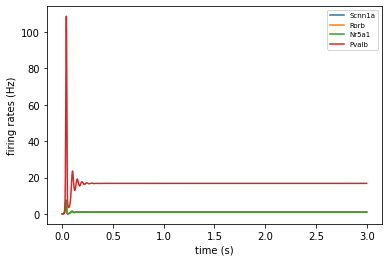

In [5]:
from bmtk.analyzer.firing_rates import plot_rates_popnet

plot_rates_popnet(
    cell_models_file='network_popnet/l4_node_types.csv', 
    rates_file='output_popnet/firing_rates.csv', 
    model_keys='model_name'
)

[**Return to the main chapter contents**](4.%20Multipopulation%20GLIF%20model.ipynb)